In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
data = pd.read_csv('Crash_Reporting_-_Drivers_Data.csv', low_memory=False)

In [51]:
data.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 02:55:00 PM,NaN,NaN,NaN,NaN,IN FRONT OF 18900 BIRDSEYE DR,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
1,MCP3254003K,230072050,Montgomery County Police,Injury Crash,12/16/2023 12:36:00 PM,Maryland (State),GERMANTOWN RD,County,MIDDLEBROOK RD,NaN,...,35,No,No,2010,TOYT,PRIUS,NO MISUSE,39.178776,-77.267190,"(39.17877577, -77.26718974)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,NaN,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"
3,MCP2674004J,230064598,Montgomery County Police,Property Damage Crash,11/05/2023 09:07:00 PM,Maryland (State),WOODFIELD RD,County,GLENDALOUGH RD,NaN,...,40,No,No,2019,DODGE,CHARGER,NO MISUSE,39.211742,-77.171461,"(39.21174219, -77.17146065)"
4,MCP25280008,230067019,Montgomery County Police,Property Damage Crash,11/18/2023 12:40:00 AM,Maryland (State),CLARKSBURG RD,Maryland (State),CLARKSBURG RD,NaN,...,20,No,No,2014,NISSAN,ROGUE,NaN,39.228915,-77.289091,"(39.22891483, -77.28909117)"


In [52]:
data_types = data.dtypes

categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
numerical_cols = [col for col in data.columns if data[col].dtype != 'object']

# Fill null values in categorical columns with the mode
for col in categorical_cols:
    mode = data[col].mode()[0]
    data[col] = data[col].fillna(mode)

# Fill null values in numerical columns with the mean
for col in numerical_cols:
    mean = data[col].mean()
    data[col] = data[col].fillna(mean)

print("Data after handling null values:")
print(data.isna().sum())

Data after handling null values:
Report Number                     0
Local Case Number                 0
Agency Name                       0
ACRS Report Type                  0
Crash Date/Time                   0
Route Type                        0
Road Name                         0
Cross-Street Type                 0
Cross-Street Name                 0
Off-Road Description              0
Municipality                      0
Related Non-Motorist              0
Collision Type                    0
Weather                           0
Surface Condition                 0
Light                             0
Traffic Control                   0
Driver Substance Abuse            0
Non-Motorist Substance Abuse      0
Person ID                         0
Driver At Fault                   0
Injury Severity                   0
Circumstance                      0
Driver Distracted By              0
Drivers License State             0
Vehicle ID                        0
Vehicle Damage Extent          

In [53]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoders = {}
for col in categorical_cols:
    data[col] = data[col].astype(str)  # Convert column to string
    encoders[col] = LabelEncoder()
    data[col] = encoders[col].fit_transform(data[col])

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [54]:
from sklearn.model_selection import train_test_split

target_column = 'Injury Severity'

# Separate features and target variable
X = data.drop(target_column, axis=1)
y = data[target_column]

# before moving to classification lets see the number of occurence for each of the prediction labels:
label_counts = y.value_counts()
print("Number of occurrences for each prediction label:")
print(label_counts)

Number of occurrences for each prediction label:
Injury Severity
1    141185
2     17482
3     11870
4      1415
0       153
Name: count, dtype: int64


In [55]:
# lets use scikit learns class balancers for the imbalanced dataset:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print("Class Weights:", class_weight_dict)

# Before balancing, let's see the number of occurrences for each prediction label
label_counts = y.value_counts()
print("Number of occurrences for each prediction label before balancing:")
print(label_counts)

Class Weights: {0: 224.9738562091503, 1: 0.24380068704182456, 2: 1.968939480608626, 3: 2.89983150800337, 4: 24.325795053003535}
Number of occurrences for each prediction label before balancing:
Injury Severity
1    141185
2     17482
3     11870
4      1415
0       153
Name: count, dtype: int64


In [56]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [57]:
label_counts_smote = pd.Series(y_train_smote).value_counts()
print("Number of occurrences for each prediction label after SMOTE:")
print(label_counts_smote)

Number of occurrences for each prediction label after SMOTE:
Injury Severity
2    112934
1    112934
3    112934
4    112934
0    112934
Name: count, dtype: int64


In [58]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb_model.predict(X_train_smote)
print("XGBoost Model Performance:")
print(classification_report(y_train_smote, y_pred_xgb))

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    112934
           1       0.93      0.95      0.94    112934
           2       0.70      0.71      0.71    112934
           3       0.75      0.65      0.70    112934
           4       0.83      0.92      0.88    112934

    accuracy                           0.85    564670
   macro avg       0.84      0.85      0.84    564670
weighted avg       0.84      0.85      0.84    564670



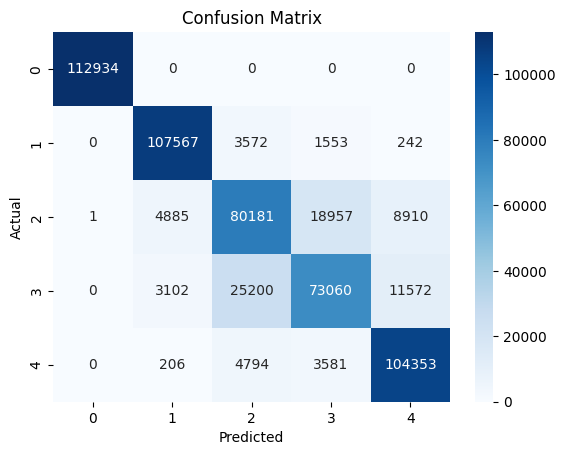

In [59]:
# plotting confusion matrix
confusion_mat = confusion_matrix(y_train_smote, y_pred_xgb)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [61]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_train_smote, y_pred_xgb)

# Print the accuracy score
print("XGBoost Model Accuracy:", accuracy)


XGBoost Model Accuracy: 0.8466803619813342


Learning rate set to 0.109311
0:	learn: 1.4121843	total: 1.72s	remaining: 28m 34s
1:	learn: 1.2843324	total: 3.3s	remaining: 27m 27s
2:	learn: 1.1912759	total: 5.52s	remaining: 30m 35s
3:	learn: 1.1181120	total: 8.35s	remaining: 34m 39s
4:	learn: 1.0605345	total: 10.9s	remaining: 36m 2s
5:	learn: 1.0122931	total: 12.4s	remaining: 34m 7s
6:	learn: 0.9723761	total: 13.7s	remaining: 32m 19s
7:	learn: 0.9383299	total: 15s	remaining: 30m 55s
8:	learn: 0.9089142	total: 16.4s	remaining: 30m 6s
9:	learn: 0.8836022	total: 18s	remaining: 29m 38s
10:	learn: 0.8616670	total: 19.3s	remaining: 28m 51s
11:	learn: 0.8419985	total: 20.4s	remaining: 28m 2s
12:	learn: 0.8248242	total: 22.4s	remaining: 28m 21s
13:	learn: 0.8097934	total: 24.5s	remaining: 28m 44s
14:	learn: 0.7967681	total: 26.3s	remaining: 28m 45s
15:	learn: 0.7844488	total: 27.6s	remaining: 28m 17s
16:	learn: 0.7741539	total: 28.9s	remaining: 27m 53s
17:	learn: 0.7645775	total: 30.1s	remaining: 27m 23s
18:	learn: 0.7556446	total: 31.3s	r

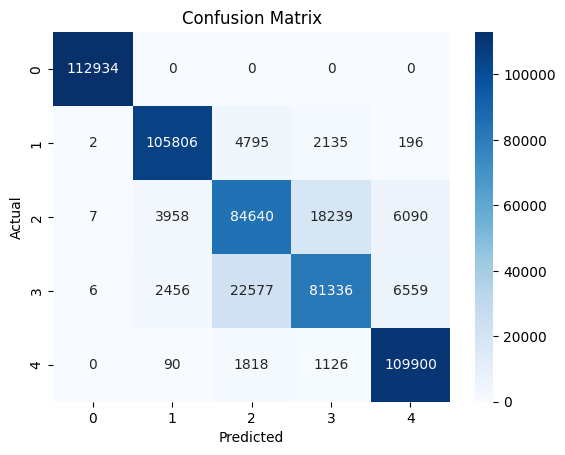

In [38]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(random_state=42)
cat_model.fit(X_train_smote, y_train_smote)
y_pred_cat = cat_model.predict(X_train_smote)
print("CatBoost Model Performance:")
print(classification_report(y_train_smote, y_pred_cat))

print(confusion_matrix(y_train_smote, y_pred_cat))

print(accuracy_score(y_train_smote, y_pred_cat))

confusion_matrix = confusion_matrix(y_train_smote, y_pred_cat)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [62]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_smote, y_train_smote)

y_pred_lgbm = lgbm_model.predict(X_train_smote)
print("LightGBM Model Performance:")
print(classification_report(y_train_smote, y_pred_lgbm))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4378
[LightGBM] [Info] Number of data points in the train set: 564670, number of used features: 42
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
LightGBM Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    112934
           1       0.92      0.95      0.93    112934
           2       0.64      0.65      0.64    112934
           3       0.68      0.53      0.59    1129

In [63]:
print("LightGBM Model Accuracy", accuracy_score(y_train_smote, y_pred_lgbm))

LightGBM Model Accuracy 0.8027060052774186
